<a href="https://colab.research.google.com/github/vyhuynh01/VQA_Project/blob/main/VQA_ViT_RoBERTa_FC_Cocodataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## __0. Download dataset__
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [ ]:
# https://drive.google.com/file/d/1kc6XNqHZJg27KeBuoAoYj70_1rT92191/view?usp=sharing
!gdown --id 1kc6XNqHZJg27KeBuoAoYj70_1rT92191

/home/s12gb1/pytorchenv/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191
From (redirected): https://drive.google.com/uc?id=1kc6XNqHZJg27KeBuoAoYj70_1rT92191&confirm=t&uuid=d5aa931c-5ad1-4050-9377-d75fa96767a8
To: /home/s12gb1/thangdd/project_vqa/vqa_coco_dataset.zip
100%|████████████████████████████████████████| 196M/196M [00:07<00:00, 24.9MB/s]


In [ ]:
!unzip -q vqa_coco_dataset.zip

## __1. Import libraries and set random seed__

In [ ]:
!pip install timm==0.8.17.dev0
!pip install torchtext==0.15.1
!pip install torchvision==0.16.0
!pip install torchaudio==2.1.0
!pip install torch==2.1.0
!pip install transformers==4.27.1

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.0.0-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached triton-2.0.0-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.0 kB)
Using cached torch-2.0.0-cp311-cp311-manylinux1_x86_64.whl (619.9 MB)
Using cached triton-2.0.0-1-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0
    Uninstalling torch-2.1.0:
      Successfully uninstalled torch-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.16.

In [ ]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel
from torchinfo import summary

In [ ]:
cuda_available = torch.cuda.is_available()
cuda_device_count = torch.cuda.device_count()

print(f"CUDA Available: {cuda_available}")
print(f"Number of CUDA Devices: {cuda_device_count}")

if cuda_available:
    for i in range(cuda_device_count):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## __2. Read dataset__

In [ ]:
train_data = []
train_set_path = 'vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

In [ ]:
val_data = []
val_set_path = 'vaq2.0.DevImages.txt'

with open(val_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

In [ ]:
test_data = []
test_set_path = 'vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)

In [ ]:
classes = set([sample['answer'] for sample in train_data])
label2idx = {
    cls_name: idx for idx, cls_name in enumerate(classes)
}
idx2label = {
    idx: cls_name for idx, cls_name in enumerate(classes)
}
print(idx2label)

{0: 'no', 1: 'yes'}


## __3. Create Pytorch dataset__

In [ ]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        label2idx,
        img_feature_extractor,
        text_tokenizer,
        device,
        transforms=None,
        img_dir='val2014-resised'
    ):
        self.data = data
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')

        if self.transforms:
            img = self.transforms(img)

        if self.img_feature_extractor:
            img = self.img_feature_extractor(images=img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()}

        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question,
                padding="max_length",
                max_length=20,
                truncation=True,
                return_tensors="pt"
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}


        label = self.data[index]['answer']
        label = torch.tensor(
            self.label2idx[label],
            dtype=torch.long
        ).to(self.device)

        sample = {
            'image': img,
            'question': question,
            'label': label
        }

        return sample

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.CenterCrop(size=180),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(3),
])

In [ ]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = VQADataset(
    train_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device,
    transforms=data_transform
)
val_dataset = VQADataset(
    val_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
test_dataset = VQADataset(
    test_data,
    label2idx=label2idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

In [ ]:
train_batch_size = 256
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [ ]:
train_sample = next(iter(train_loader))
train_sample

{'image': {'pixel_values': tensor([[[[-0.7647, -0.7490, -0.7098,  ..., -0.7176, -0.7255, -0.7333],
            [-0.7725, -0.7569, -0.7176,  ..., -0.7176, -0.7255, -0.7255],
            [-0.7647, -0.7569, -0.7333,  ..., -0.7098, -0.7176, -0.7255],
            ...,
            [-0.7804, -0.7725, -0.7725,  ..., -0.7725, -0.7882, -0.7961],
            [-0.7804, -0.7725, -0.7647,  ..., -0.7804, -0.7882, -0.7961],
            [-0.7725, -0.7725, -0.7725,  ..., -0.7725, -0.7882, -0.7961]],
  
           [[-0.7098, -0.6941, -0.6549,  ..., -0.6471, -0.6784, -0.6863],
            [-0.7176, -0.7020, -0.6627,  ..., -0.6392, -0.6706, -0.6784],
            [-0.7098, -0.7020, -0.6784,  ..., -0.6392, -0.6706, -0.6863],
            ...,
            [-0.7333, -0.7333, -0.7255,  ..., -0.7333, -0.7412, -0.7412],
            [-0.7333, -0.7255, -0.7255,  ..., -0.7333, -0.7412, -0.7412],
            [-0.7333, -0.7255, -0.7255,  ..., -0.7333, -0.7333, -0.7412]],
  
           [[-0.6941, -0.6784, -0.6392,  ...,

In [ ]:
print(f"Images batch shape: {train_sample['image']['pixel_values'].shape}")
print(f"Question (input_ids) batch shape: {train_sample['question']['input_ids'].shape}")
print(f"Question (attention_mask) batch shape: {train_sample['question']['attention_mask'].shape}")
print(f"Labels batch shape: {train_sample['label'].shape}")

Images batch shape: torch.Size([256, 3, 224, 224])
Question (input_ids) batch shape: torch.Size([256, 20])
Question (attention_mask) batch shape: torch.Size([256, 20])
Labels batch shape: torch.Size([256])


In [ ]:
val_sample = next(iter(val_loader))
print(f"Images batch shape: {val_sample['image']['pixel_values'].shape}")
print(f"Question (input_ids) batch shape: {val_sample['question']['input_ids'].shape}")
print(f"Question (attention_mask) batch shape: {val_sample['question']['attention_mask'].shape}")
print(f"Labels batch shape: {val_sample['label'].shape}")

Images batch shape: torch.Size([32, 3, 224, 224])
Question (input_ids) batch shape: torch.Size([32, 20])
Question (attention_mask) batch shape: torch.Size([32, 20])
Labels batch shape: torch.Size([32])


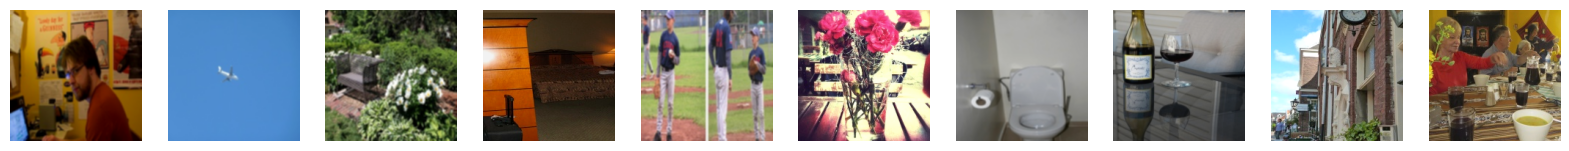

In [ ]:
img_dir='val2014-resised/'
img_to_show = 10
shift = 10
test_imgs = [
    os.path.join(img_dir, sample['image_path']) for sample in train_data[shift:shift+img_to_show]
]
fig, axes = plt.subplots(nrows=1, ncols=img_to_show, figsize=(20, 4))
for ax, img_path in zip(axes, test_imgs):
    img_pil = Image.open(img_path).convert('RGB')
    preprocessed_img = data_transform(img_pil)
    ax.imshow(preprocessed_img)
    ax.axis('off')
plt.show()

## __4. Create VQA model__

In [ ]:
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        outputs = self.model(**inputs)

        return outputs.pooler_output

In [ ]:
class Classifier(nn.Module):
    def __init__(
        self,
        hidden_size=512,
        dropout_prob=0.2,
        n_classes=2
    ):
        super(Classifier,self).__init__()
        self.fc1 = nn.Linear(768 * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_size, n_classes)

    def forward(self,x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
class VQAModel(nn.Module):
    def __init__(
        self,
        visual_encoder,
        text_encoder,
        classifier
    ):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier


    def forward(self, image, answer):
        text_out = self.text_encoder(answer)
        image_out = self.visual_encoder(image)

        x = torch.cat((image_out, text_out), dim=1)
        x = self.classifier(x)

        return x

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n,p in self.visual_encoder.named_parameters():
                p.requires_grad = False
        if textual:
            for n,p in self.text_encoder.named_parameters():
                p.requires_grad = False
        if clas:
            for n,p in self.classifier.named_parameters():
                p.requires_grad = False

In [ ]:
n_classes = len(classes)
hidden_size = 256
dropout_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(
    hidden_size=hidden_size,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkp

In [ ]:
inputs = next(iter(train_loader))
image = inputs['image']
question = inputs['question']

model_summary = summary(model, input_data=(image, question), verbose=1)
print(model_summary)


Layer (type:depth-idx)                                            Output Shape              Param #
VQAModel                                                          [256, 2]                  --
├─TextEncoder: 1-1                                                [256, 768]                --
│    └─RobertaModel: 2-1                                          [256, 768]                --
│    │    └─RobertaEmbeddings: 3-1                                [256, 20, 768]            (39,000,576)
│    │    └─RobertaEncoder: 3-2                                   [256, 20, 768]            (85,054,464)
│    │    └─RobertaPooler: 3-3                                    [256, 768]                (590,592)
├─VisualEncoder: 1-2                                              [256, 768]                --
│    └─ViTModel: 2-2                                              [256, 768]                --
│    │    └─ViTEmbeddings: 3-4                                    [256, 197, 768]           (742,656)
│    │    └

In [ ]:
inputs = next(iter(train_loader))

model.eval()
with torch.no_grad():
    image = inputs['image']
    question = inputs['question']
    output = model(image, question)
    print(output.shape)

torch.Size([256, 2])


## __5. Training__

In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total

    return loss, acc

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, inputs in enumerate(train_loader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(
            model, val_loader,
            criterion
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses

In [ ]:
lr = 1e-3
epochs = 50
scheduler_step_size = epochs * 0.8
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

EPOCH 1:	Train loss: 0.7006	Val loss: 0.6895	Val Acc: 0.5399590163934426
EPOCH 2:	Train loss: 0.6846	Val loss: 0.6835	Val Acc: 0.5660860655737705
EPOCH 3:	Train loss: 0.6771	Val loss: 0.6867	Val Acc: 0.5461065573770492
EPOCH 4:	Train loss: 0.6706	Val loss: 0.6784	Val Acc: 0.5691598360655737
EPOCH 5:	Train loss: 0.6601	Val loss: 0.6779	Val Acc: 0.5763319672131147
EPOCH 6:	Train loss: 0.6530	Val loss: 0.6763	Val Acc: 0.5758196721311475
EPOCH 7:	Train loss: 0.6390	Val loss: 0.6696	Val Acc: 0.5819672131147541
EPOCH 8:	Train loss: 0.6243	Val loss: 0.6795	Val Acc: 0.5927254098360656
EPOCH 9:	Train loss: 0.6107	Val loss: 0.6978	Val Acc: 0.5753073770491803
EPOCH 10:	Train loss: 0.5930	Val loss: 0.6738	Val Acc: 0.5952868852459017
EPOCH 11:	Train loss: 0.5675	Val loss: 0.6756	Val Acc: 0.6014344262295082
EPOCH 12:	Train loss: 0.5474	Val loss: 0.6826	Val Acc: 0.6091188524590164
EPOCH 13:	Train loss: 0.5255	Val loss: 0.6849	Val Acc: 0.6121926229508197
EPOCH 14:	Train loss: 0.4976	Val loss: 0.6948	V

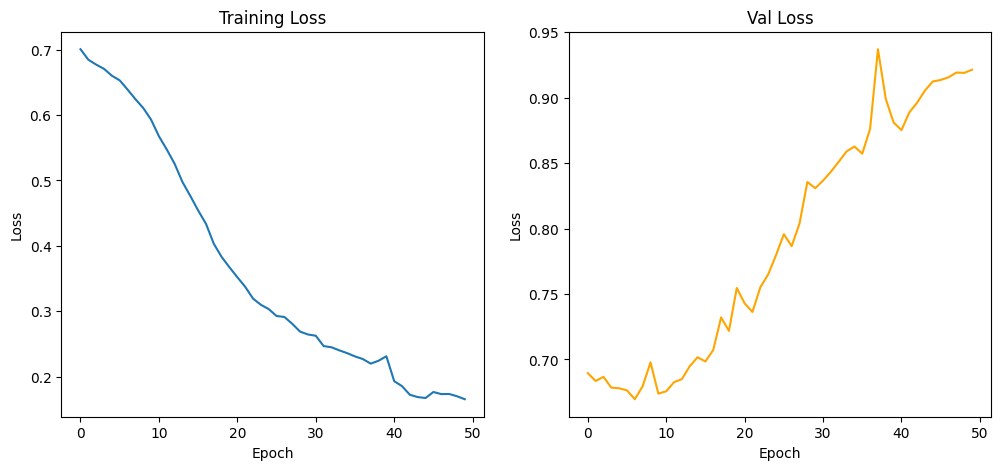

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

## __6. Evaluation__

In [ ]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val/test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val/test dataset
Val accuracy:  0.6664959016393442
Test accuracy:  0.6533135509396637


## __7. Inference__

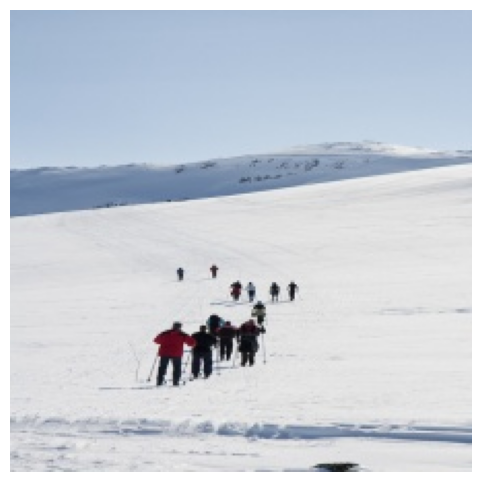

Question: Are there any trees visible ?
Groundtruth: no
Predicted: no


In [ ]:
idx = 10
img_name = test_data[idx]['image_path']
img_path = os.path.join(img_dir, img_name)
question = test_data[idx]['question']
label = test_data[idx]['answer']

question_processed = text_tokenizer(
    question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_tensors="pt"
).to(device)


img = Image.open(img_path).convert("RGB")
img_processed = img_feature_extractor(images=img, return_tensors="pt").to(device)

model.eval()
with torch.no_grad():
    output = model(img_processed, question_processed)
    pred = torch.argmax(output, dim=1).item()

plt.figure(figsize=(6, 6))
plt.imshow(np.array(img))
plt.axis('off')
plt.show()

print(f'Question: {question}')
print(f'Groundtruth: {label}')
print(f'Predicted: {idx2label[pred]}')